# ЛР4. Начальная настройка весов полносвязных и сверточных нейронных сетей

In [1]:
%tensorflow_version 2.x
import os
import cv2
import numpy as np
from time import time
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!cp /content/gdrive/'My Drive'/datasets/asl-alphabet.zip .

import zipfile
with zipfile.ZipFile('asl-alphabet.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

!ls

asl-alphabet.zip  gdrive  sample_data  test  train


### Описание датасета

[Набор данных ASL Alphabet](https://www.kaggle.com/grassknoted/asl-alphabet) представляет собой набор изображений из американского языка жестов. Набор обучающих данных содержит 87 000 изображений размером 200х200 пикселей. Есть 29 классов , из которых 26-для букв A-Z и 3 класса SPACE, DELETE и NOTHING. В каждом классе 3000 изображений.

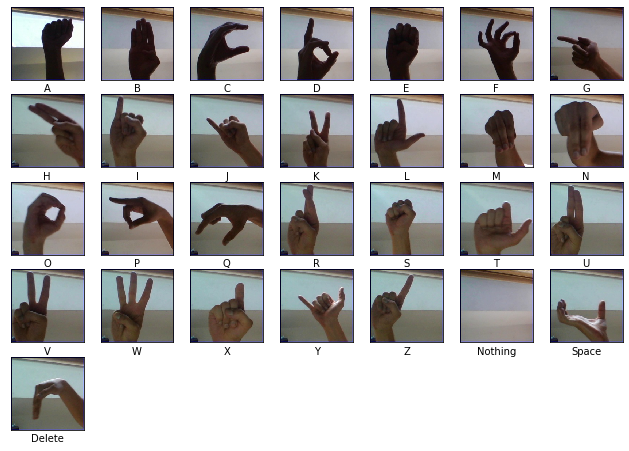

In [0]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'Nothing', 'Space', 'Delete']
plt.figure(figsize=(11, 11))
for i in range (0,29):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path = "test/{0}.jpg".format(classes[i])
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(classes[i])

### Загружаем данные

In [3]:
# Загружаем изображения
def load_data(train_dir):
    images = []
    labels = []
    size = 32,32
    index = -1
    for folder in os.listdir(train_dir):
        index +=1
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(index)
    
    images = np.array(images)
    # Нормализуем данные
    images = images.astype('float32')/255.0
    # Преобразуем метки в one-hot-encoding
    labels = utils.to_categorical(labels)
    # Разделяем данные на тренировочную и тестовую выборки
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1)
    
    print('Loaded', len(x_train),'images for training,','Train data shape =', x_train.shape)
    print('Loaded', len(x_test),'images for testing','Test data shape =', x_test.shape)
    
    return x_train, x_test, y_train, y_test

start = time()
x_train, x_test, y_train, y_test = load_data('train/')
print('Loading:', time() - start)

Loaded 78300 images for training, Train data shape = (78300, 32, 32, 3)
Loaded 8700 images for testing Test data shape = (8700, 32, 32, 3)
Loading: 59.126553535461426


#### Autoencoder

In [0]:
def autoencoder_train(encoder, decoder, data, epochs, batch, learning_rate=0.0001):
    autoencoder = Sequential([encoder, decoder])
    adam = Adam(lr=learning_rate)
    autoencoder.compile(optimizer=adam, loss='mse')
    start = time()
    autoencoder.fit(data, data, epochs=epochs, batch_size=batch)
    train_time = time() - start

    return encoder, data, train_time

#### FCNN + Autoencoder

In [0]:
def FCNN(x_train, x_test, y_train, y_test, epochs, batch, neurons, learning_rate=0.001):
    inp_image = Input(shape = (32, 32, 3))
    vec_image = Flatten()(inp_image)
    encoder_res = Dense(neurons, activation='sigmoid')(vec_image)

    inp_decoder = Input(shape=(neurons,))
    vec_decode = Dense(32*32*3, activation='sigmoid')(inp_decoder)
    decoder_res = Reshape((32, 32, 3))(vec_decode)

    encoder = Model(inp_image, encoder_res, name="encoder")
    decoder = Model(inp_decoder, decoder_res, name="decoder")
    encoder, x_train, ae_train_time = autoencoder_train(encoder, decoder, x_train, epochs, batch)

    model = Sequential()
    for layer in encoder.layers:
        model.add(layer)

    model.add(Dense(29, activation='softmax'))

    adam = Adam(lr=learning_rate) 
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    start = time()
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch, validation_split=0.1, shuffle = True)
    train_time = time() - start
    print('\nAutoencoder train_time: ', ae_train_time)
    print('\nFCNN Train time: ', train_time)
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('\nFCNN Test accuracy: ', test_acc)

In [0]:
def FCNN(x_train, x_test, y_train, y_test, epochs, batch, neurons, learning_rate=0.001):
    inp_image = Input(shape = (32, 32, 3))
    vec_image = Flatten()(inp_image)
    encoder_res = Dense(neurons, activation='sigmoid')(vec_image)

    inp_decoder = Input(shape=(neurons,))
    vec_decode = Dense(32*32*3, activation='sigmoid')(inp_decoder)
    decoder_res = Reshape((32, 32, 3))(vec_decode)

    encoder = Model(inp_image, encoder_res, name="encoder")
    decoder = Model(inp_decoder, decoder_res, name="decoder")
    encoder, x_train, ae_train_time = autoencoder_train(encoder, decoder, x_train, epochs, batch)

    model = Sequential()
    for layer in encoder.layers:
        model.add(layer)

    model.add(Dense(29, activation='softmax'))

    adam = Adam(lr=learning_rate) 
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    start = time()
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch, validation_split=0.1, shuffle = True)
    train_time = time() - start
    print('\nAutoencoder train_time: ', ae_train_time)
    print('\nFCNN Train time: ', train_time)
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('\nFCNN Test accuracy: ', test_acc)

In [0]:
FCNN(x_train, x_test, y_train, y_test, epochs = 10, batch = 128, neurons = 1024)

Train on 78300 samples
Epoch 1/10
78300/78300 [==============================] - 3s 44us/sample - loss: 0.0203
Epoch 2/10
78300/78300 [==============================] - 3s 41us/sample - loss: 0.0100
Epoch 3/10
78300/78300 [==============================] - 3s 40us/sample - loss: 0.0078
Epoch 4/10
78300/78300 [==============================] - 3s 40us/sample - loss: 0.0065
Epoch 5/10
78300/78300 [==============================] - 3s 40us/sample - loss: 0.0057
Epoch 6/10
78300/78300 [==============================] - 3s 41us/sample - loss: 0.0051
Epoch 7/10
78300/78300 [==============================] - 3s 40us/sample - loss: 0.0046
Epoch 8/10
78300/78300 [==============================] - 3s 40us/sample - loss: 0.0043
Epoch 9/10
78300/78300 [==============================] - 3s 41us/sample - loss: 0.0040
Epoch 10/10
78300/78300 [==============================] - 3s 41us/sample - loss: 0.0037
Model: "sequential_79"
_________________________________________________________________
Layer (

#### CNN + Autoencoder

In [0]:
def CNN(x_train, y_train, x_test, y_test, epochs, batch, neurons, learning_rate=0.001):
    cur_data = x_train.copy() 
    encoder_1 = Sequential()
    encoder_1.add(Conv2D(32, (3, 3), activation='tanh', padding='same', input_shape=(32,32,3)))
    encoder_1.add(MaxPooling2D(pool_size=(2, 2)))
    decoder_1 = Sequential([Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', input_shape=(16, 16, 32))])
    encoder_1, cur_data, cnn_ae_train_time = autoencoder_train(encoder_1, decoder_1, cur_data, epochs, batch)
    cur_data = encoder_1.predict(cur_data) 

    cur_data = cur_data.reshape(cur_data.shape[0], 8192)  
    encoder_2 = Sequential([Dense(512, activation='sigmoid')])
    decoder_2 = Sequential([Dense(8192, activation='sigmoid')])
    encoder_2, cur_data, fcnn_ae_train_time = autoencoder_train(encoder_2, decoder_2, cur_data, epochs, batch)
    
    model = Sequential([encoder_1, Flatten(), encoder_2]) 
    model.add(Dense(29, activation='softmax'))

    adam = Adam(lr=learning_rate) 
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    start = time()
    model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1, shuffle = True)
    train_time = time() - start
    print('\nAutoencoder train_time: ', cnn_ae_train_time + fcnn_ae_train_time)
    print('\nCNN Train time: ', train_time)
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('\nTest loss:', test_loss)
    print('\nCNN Test accuracy:', test_acc)

In [12]:
CNN(x_train, y_train, x_test, y_test, epochs = 5, batch = 128, neurons = 512)

Train on 78300 samples
Epoch 1/5
78300/78300 [==============================] - 3s 40us/sample - loss: 0.0493
Epoch 2/5
78300/78300 [==============================] - 3s 37us/sample - loss: 0.0091
Epoch 3/5
78300/78300 [==============================] - 3s 38us/sample - loss: 0.0067
Epoch 4/5
78300/78300 [==============================] - 3s 37us/sample - loss: 0.0053
Epoch 5/5
78300/78300 [==============================] - 3s 36us/sample - loss: 0.0044
Train on 78300 samples
Epoch 1/5
78300/78300 [==============================] - 5s 58us/sample - loss: 0.0540
Epoch 2/5
78300/78300 [==============================] - 4s 55us/sample - loss: 0.0427
Epoch 3/5
78300/78300 [==============================] - 4s 56us/sample - loss: 0.0421
Epoch 4/5
78300/78300 [==============================] - 4s 55us/sample - loss: 0.0408
Epoch 5/5
78300/78300 [==============================] - 4s 56us/sample - loss: 0.0396
Model: "sequential_48"
_____________________________________________________________